# Background Information

When an analyst estimates the price of a house, they need to consider many predictors, including its location, size, and construction quality. Luckily, machine learning models exist to do the work for them. In this project, I trained and evaluated regression models to predict the prices of houses. I used a dataset from OpenIntro of 2930 houses in Ames, Iowa with 79 predictors. To download the dataset and read the predictor descriptions, [click here](https://www.openintro.org/data/index.php?data=ames). 

# Import Libraries and Data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import statsmodels

# Data processing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate

# Machine learning models
from sklearn.linear_model import LinearRegression

In [4]:
# Use the Order column (unique identifier for each house) as the row index
houses_data = pd.read_csv('ames_houses_data.csv', index_col="Order")
X = houses_data.drop(columns=["price"])
y = houses_data.loc[:, "price"]
print("X size: ", X.shape)

X size:  (2930, 80)


For simplicity, I only used countinuous, discrete, and ordinal predictors to train my models. Hence, I removed all of the nominal predictors from the dataset.

In [5]:
X = X.select_dtypes(include="number")

# Manually remove nominal columns encoded with integers
X.drop(columns=["MS.SubClass", "Mo.Sold", "PID"], inplace=True) 

print("X size after removing unwanted predictors: ", X.shape)

X size after removing unwanted predictors:  (2930, 34)


I then split the dataset into a training set (80%) and a test set (20%). 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train size: ", X_train.shape)
print("X_test size: ", X_test.shape)

X_train size:  (2344, 34)
X_test size:  (586, 34)


# Exploratory Data Analysis

## Distributions of the variables

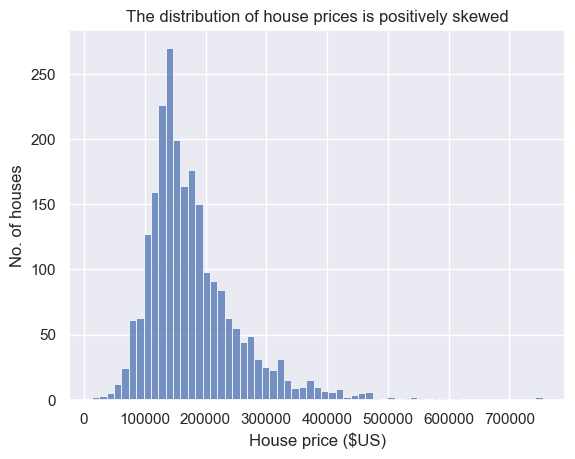

In [7]:
# Distribution of house prices (the target)
sns.histplot(y_train)
plt.title("The distribution of house prices is positively skewed")
plt.xlabel("House price ($US)")
plt.ylabel("No. of houses")
plt.show()

The distribution of house prices is positively skewed due to a few very expensive houses.

In [8]:
# Distributions of the predictors. Commented out since it takes a while to run.
# X_train.hist(figsize=(15, 17))
# plt.show()

![](predictor_histograms.png)

Many of the predictors (Pool.Area, Screen.Porch) are 0 for most of the houses. For example:
- **Pool.Area**: Pool area 
- **Screen.Porch**: Screen porch area

This is because most houses do not have these amenities.

## Correlations between variables

Due to the large number of predictors, a correlation heatmap would be hard to read. Hence, I did not include one.

In [9]:
correlation_matrix = pd.concat([X_train, y_train], axis = 1).corr()
lower_triangle_mask = np.tril(np.ones(correlation_matrix.shape), k = -1).astype(bool)
# Replace all values above the lower triangle with NaN
correlation_matrix = correlation_matrix.where(lower_triangle_mask)

### Correlations with the target (house price)

In [10]:
most_positive = correlation_matrix.loc["price"].sort_values(ascending=False)[0:5]
print(f"The {len(most_positive)} predictors that were most positively correlated with house price were:\n", 
      most_positive, "\n", sep="")

most_negative = correlation_matrix.loc["price"].sort_values(ascending=True)[0:1]
print(f"The predictor that was most negatively correlated with house price was:\n", 
       most_negative, sep="")

The 5 predictors that were most positively correlated with house price were:
Overall.Qual     0.795298
area             0.698315
Garage.Cars      0.644304
Garage.Area      0.633106
Total.Bsmt.SF    0.612256
Name: price, dtype: float64

The predictor that was most negatively correlated with house price was:
Enclosed.Porch   -0.130722
Name: price, dtype: float64


- **Overall.Qual**: Quality of the construction materials and workmanship on a scale of 1 to 10. 
- **area**: The total living area above the ground. 
- **Garage.Cars**: No. of cars that can fit in the garage. 
- **Total.Bsmt.SF**: The area of the basement.
- **Garage.Area**: Area of the garage. (Notice that is is highly correlated with GarageCars). 

There were no quantitative predictors that were significantly negatively correlated with the house price.

### Correlations between predictors

In [11]:
most_positive = correlation_matrix.stack().sort_values(ascending=False)[0:5]
print(f"The {len(most_positive)} predictor pairs that were most positively correlated were:\n", 
      most_positive, "\n", sep="")

most_negative = correlation_matrix.stack().sort_values(ascending=True)[0:1]
print(f"The predictor pair that was most negatively correlated was:\n", 
       most_negative, sep="")

The 5 predictor pairs that were most positively correlated were:
Garage.Area    Garage.Cars      0.883871
Garage.Yr.Blt  Year.Built       0.824690
X1st.Flr.SF    Total.Bsmt.SF    0.813946
TotRms.AbvGrd  area             0.806434
price          Overall.Qual     0.795298
dtype: float64

The predictor pair that was most negatively correlated was:
Bsmt.Unf.SF  BsmtFin.SF.1   -0.47883
dtype: float64


# Training Set Procesesing

Each step in the data processing can be represented by a scikit-learn transformer object. These transfromers can be assembled into a Pipeline object, which can be used to apply all of the data processing steps to new data in one method call.

## Removing Outliers

Outliers are data points that have variable values that are far away from other data points. They can worsen the fit on the rest of the data points. Since comprehensive outlier detection and handling is quite complicated, I will only consider a few obvious outliers. From the distribution of house prices plotted above, there are a few houses with house prices that are much more expensive than the rest. Hence, I will remove all houses with house prices above $500,000.

In [12]:
outlier_mask = y_train[y_train < 500_000].index
X_train = X_train[X_train.index.isin(outlier_mask)]
y_train = y_train[y_train < 500_000]

## Data Standardization

I will use scikit-learn's StandardScaler transformer to standardize each predictor variable to a mean of 0 and a standard deviation of 1. This will improve the training speed and performance of the regression models.

## Handling missing data

Regression models cannot be trained on data with missing values. The simplest solution is to delete data points with missing values. But data points with a few missing predictor values still have a lot of information in their other predictor values. So a better option is to replace missing data with a best guess based on other data in the dataset (data imputation). 

I will use scikit-learn's KNNImputer transformer to impute missing data. For each data point with missing predictor values, k-Nearest Neighbors:
1. Identifies the k data points that are closest to it in the predictor space.
2. Takes the averages of their predictor values and uses them to impute the missing values.  

## Data Processing Pipeline

In [13]:
data_processing = make_pipeline(StandardScaler(), KNNImputer())

# Multiple Linear Regresssion

One of the simplest models we can use to predict the house prices is multiple linear regression. I will now train a multiple linear regression model on the entire training set then fit it on the training set to obtain a residual plot.

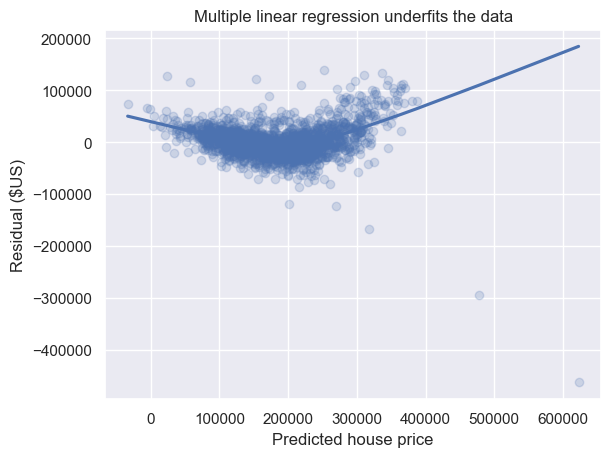

In [14]:
linear_regression = make_pipeline(data_processing, LinearRegression())
lr_train = linear_regression.fit(X_train, y_train)
pred_y_train = pd.Series(lr_train.predict(X_train), index=X_train.index)
train_residuals = y_train - pred_y_train

sns.regplot(x=pred_y_train, y=train_residuals, 
            scatter_kws={"alpha": 0.2},
            lowess=True) #locally weighted linear regression 

plt.title("Multiple linear regression underfits the data")
plt.xlabel("Predicted house price")
plt.ylabel("Residual ($US)")
plt.show()

The residual plot is curved, which indicates that the target is not a linear combination of the predictors. Hence, a more complex model might yield a better fit.

Since the test set is reserved for the evaluation of our final model, I will use cross-validation to evaluate the multiple linear regression model.

In [351]:
linear_scores = cross_validate(linear_regression, 
                               X_train, y_train, 
                               scoring="neg_root_mean_squared_error", 
                               return_estimator=True)

print("Negative RMSE scores: ", linear_scores["test_score"])

Negative RMSE scores:  [-37597.01003184 -29088.29803635 -27742.30645566 -35198.67921134
 -27683.13041834]


The RMSE score is the proportion of the variation in house prices that is explained by the model.

## Regularization

Machine learning models have hyperparameters, which control the values of the model parameters obtained through training. Lasso regression uses $\lambda$ (a hyperparameter) to control the magnitudes of the obtained regression coefficients (the model parameters). 

A good set of hyperparameter values is determined empirically by training and evaluating models with different hyperparameter values. For each set of hyperparameter values, cross-validation is used to get a more accurate measurement of the model's performance.

In [94]:
param_grid = {'lambda': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(, param_grid, cv=5)

SyntaxError: invalid syntax (2869824817.py, line 2)

# Ensemble Models?